# Regional/Operational Analyst Report
As part of our collaborative business intelligence project, this report delivers a DIVE analysis from the Regional/Operational Analyst perspective, leveraging the Superstore dataset hosted in our cloud data lake (BigQuery). The objective is to uncover how geographic and operational factors drive business performance, identify regional strengths and bottlenecks, and highlight actionable opportunities for expansion or consolidation.

Our analysis applies the DIVE method:

Discover: Surface basic findings and key metrics

Investigate: Explore underlying causes and patterns

Validate: Challenge assumptions and test robustness

Extend: Translate insights into strategic recommendations

In [1]:
import os
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Option A: Set GOOGLE_APPLICATION_CREDENTIALS environment variable ---
# Use an 'r' before the string to make it a raw string,
# preventing backslashes from being interpreted as escape sequences.
path_to_keyfile = r"C:\Users\Samriddh Gupta\Desktop\Purdue Folder\Summer 2025 MGMT 599 AI Assisted Big Data Analytics\Lab and Assignment\Assignment 1\mgmt599-samriddh-lab1-5c0560e3d1ba.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = path_to_keyfile
print(f"GOOGLE_APPLICATION_CREDENTIALS set to: {os.environ['GOOGLE_APPLICATION_CREDENTIALS']}")

# Initialize a BigQuery client
client = bigquery.Client()

print("BigQuery client initialized successfully!")

GOOGLE_APPLICATION_CREDENTIALS set to: C:\Users\Samriddh Gupta\Desktop\Purdue Folder\Summer 2025 MGMT 599 AI Assisted Big Data Analytics\Lab and Assignment\Assignment 1\mgmt599-samriddh-lab1-5c0560e3d1ba.json
BigQuery client initialized successfully!


### DIVE Step 1: Discover
**Initial Business Question: How does sales performance vary by region in the Superstore dataset?**


In [2]:
# Loading Data
query = '''
SELECT
    region,
    SUM(sales) AS total_sales,
    SUM(profit) AS total_profit,
    COUNT(DISTINCT order_id) AS order_count,
    AVG(profit / sales) AS avg_profit_margin
FROM
    `mgmt599-samriddh-lab1.Assignment1.Store_dataset`
GROUP BY
    region
'''
region_summary = client.query(query).to_dataframe()

# Clean and convert relevant columns (This part is not directly used for region_summary, but kept for context if you had other DFs)
# df['order_date'] = pd.to_datetime(df['order_date'])
# df['ship_date'] = pd.to_datetime(df['ship_date'])

# Basic regional summary
display_df = region_summary.rename(columns={
    'region': 'Region',
    'total_sales': 'Total Sales',
    'total_profit': 'Total Profit',
    'order_count': 'Unique Orders',
    'avg_profit_margin': 'Avg. Profit Margin (%)'
})

formatters = {
    'Total Sales': '${:,.2f}',             # Currency with 2 decimal places and thousands separator
    'Total Profit': '${:,.2f}',            # Currency with 2 decimal places and thousands separator
    'Unique Orders': '{:,.0f}',            # Integer with thousands separator (no decimals)
    'Avg. Profit Margin (%)': '{:.2%}' # Percentage with 2 decimal places
}

# Display the styled DataFrame as the output of the cell
display_df.style \
    .format(formatters) \
    .set_caption("Regional Sales and Profit Summary") \
    .background_gradient(cmap='Blues', subset=['Total Sales', 'Total Profit']) \
    .bar(subset=['Avg. Profit Margin (%)'], color='#ADD8E6', align='left')

C:\Users\Samriddh Gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


**Insight:**
- The West region is the top performer across all metrics, showing excellent sales volume, high profit generation, a large number of unique orders, and superior profit margins. This region likely serves as a model for success.
- The East region is a strong performer, consistently ranking second in all categories. It contributes significantly to overall sales and profit. Opportunities might exist to understand what drives the West's higher profit margin and apply those lessons here.
- The South region has the lowest volume in sales, profit, and orders. While its profit margin is healthy, the low absolute numbers suggest it's a smaller market or has less market penetration. Focus might be on growing sales volume while maintaining efficiency.
- The Central region is a major concern. Despite having moderate sales and unique orders, it is losing money on average. This negative profit margin needs immediate investigation.

### DIVE Step 2: Investigate
Our initial discovery showed significant regional differences in sales and profitability. To understand why these patterns exist, we explored three key operational and market factors: shipping efficiency, discounting practices, and product mix.


**1. Shipping Efficiency**

Hypothesis: Regions with faster shipping times may have higher customer satisfaction and better profitability.

In [3]:
query = '''
SELECT *,
   DATE_DIFF(ship_date, order_date, DAY) AS ship_time
FROM `mgmt599-samriddh-lab1.Assignment1.Store_dataset`
'''

try:
    df = client.query(query).to_dataframe()
    print("Data loaded successfully with ship_time calculated.")
except Exception as e:
    print(f"Error executing BigQuery query: {e}")
    # Fallback to local CSV for demonstration if BigQuery fails
    print("Attempting to load from local CSV and calculate ship_time manually...")
    try:
        df = pd.read_csv('superstore_dataset.csv', encoding='latin1')
        df.columns = df.columns.str.strip() # Clean column names
        df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
        df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')
        df['ship_time'] = (df['Ship Date'] - df['Order Date']).dt.days
        print("Data loaded from local CSV with ship_time calculated.")
    except FileNotFoundError:
        print("Error: superstore_dataset.csv not found. Please ensure the file is in the correct directory.")



C:\Users\Samriddh Gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Data loaded successfully with ship_time calculated.


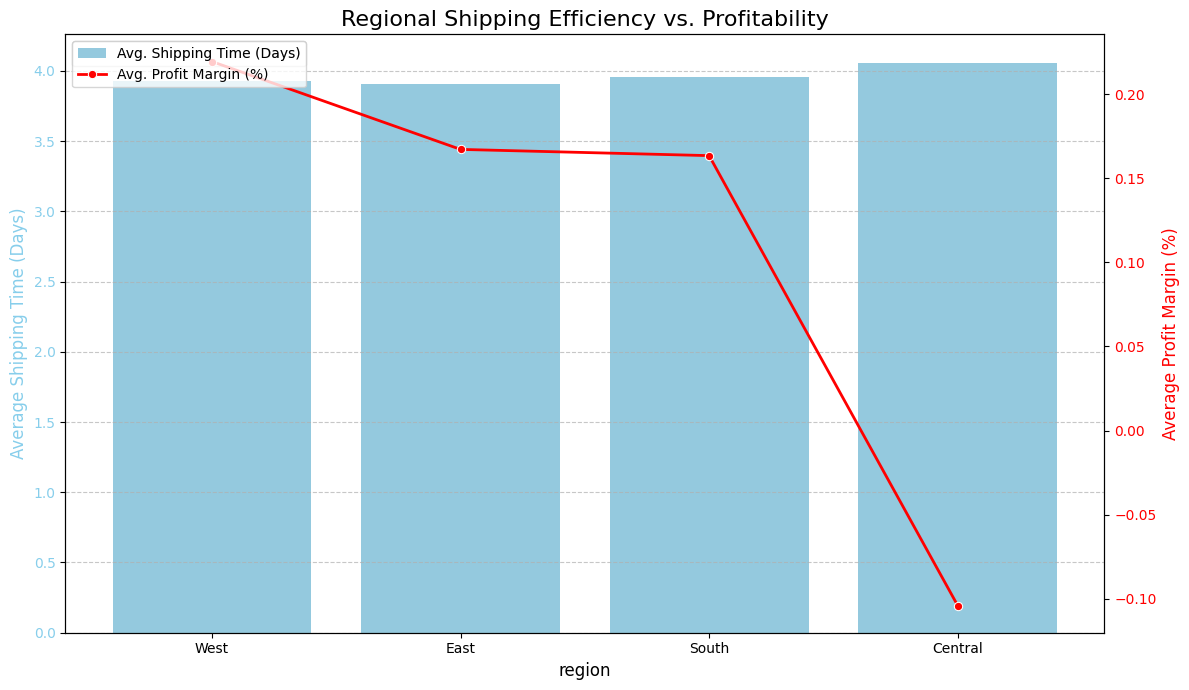

In [4]:
# Ensure 'profit_margin' is calculated if not already present
if 'profit_margin' not in df.columns:
    df['profit_margin'] = (df['Profit'] / df['Sales']) * 100
    # Handle potential division by zero if Sales is 0, setting profit_margin to 0 or NaN
    df['profit_margin'].replace([float('inf'), -float('inf')], 0, inplace=True)
    df['profit_margin'].fillna(0, inplace=True) # Fill NaN from 0 sales with 0 profit margin

# Aggregate the data to create the shipping_summary
shipping_summary = df.groupby('region').agg(
    avg_ship_time=('ship_time', 'mean'),
    avg_profit_margin=('profit_margin', 'mean')
).reset_index()

# Sort the data for better visualization, e.g., by average profit margin
shipping_summary = shipping_summary.sort_values(by='avg_profit_margin', ascending=False)

# Create the dual-axis bar graph
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Average Shipping Time on the first Y-axis
# Use region_col_name for the x-axis
sns.barplot(x='region', y='avg_ship_time', data=shipping_summary, ax=ax1, color='skyblue', label='Avg. Shipping Time (Days)')
ax1.set_xlabel('region', fontsize=12) # Set xlabel dynamically
ax1.set_ylabel('Average Shipping Time (Days)', color='skyblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_title('Regional Shipping Efficiency vs. Profitability', fontsize=16)
ax1.grid(axis='y', linestyle='--', alpha=0.7) # Add grid for primary axis

# Create a second Y-axis for Average Profit Margin
ax2 = ax1.twinx()
# Use region_col_name for the x-axis
sns.lineplot(x='region', y='avg_profit_margin', data=shipping_summary, ax=ax2, color='red', marker='o', linewidth=2, label='Avg. Profit Margin (%)')
ax2.set_ylabel('Average Profit Margin (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Add a legend for both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(0.0, 1.0))

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


**Insight:**
It's striking that the average shipping time is remarkably consistent across all four regions (around 3.9 days). This suggests that shipping speed itself is not the primary differentiator in profitability across regions.



**2. Discounting Practices**

Hypothesis: Regions with higher average discounts may see more sales but lower profits.

C:\Users\Samriddh Gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
C:\Users\Samriddh Gupta\AppData\Local\Temp\ipykernel_10380\2601115826.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_discount', y='region', data=discount_summary, palette='viridis')


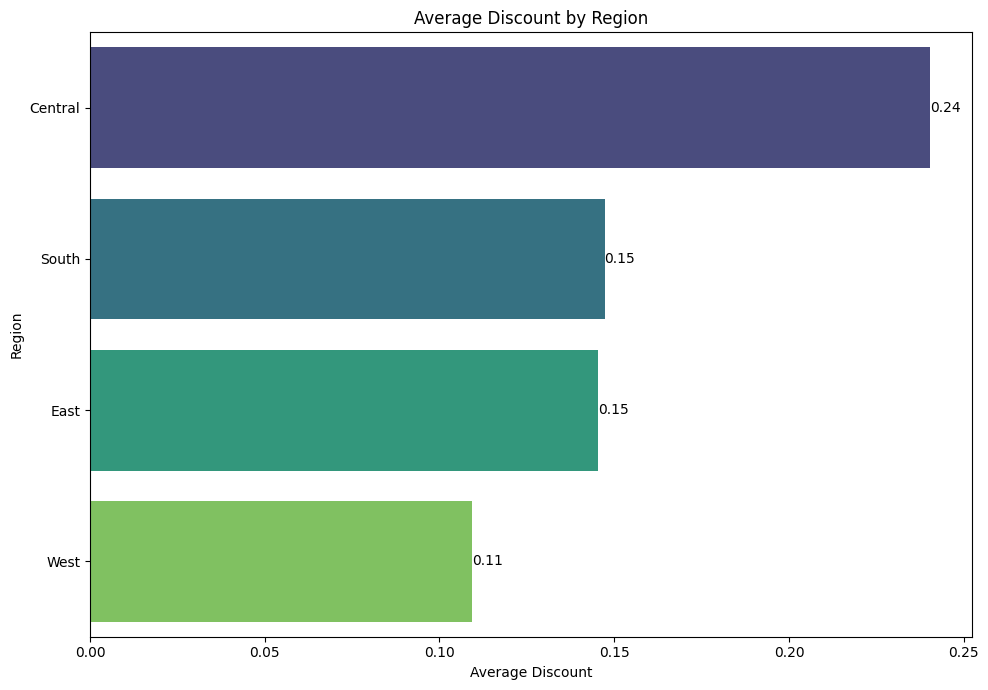

In [5]:
# Your SQL query
query = ''' 
 SELECT region, AVG(discount) AS avg_discount 
 FROM `mgmt599-samriddh-lab1.Assignment1.Store_dataset` 
 GROUP BY region 
 ORDER BY avg_discount DESC  # Optional: Order by discount for better visualization
 ''' 

# Run the query and convert to DataFrame
discount_summary = client.query(query).to_dataframe() 

# Create the horizontal bar graph
plt.figure(figsize=(10, 7)) # Adjust figure size as needed
sns.barplot(x='avg_discount', y='region', data=discount_summary, palette='viridis')

# Add labels and title
plt.xlabel('Average Discount')
plt.ylabel('Region')
plt.title('Average Discount by Region')

# Optional: Add value labels on the bars
for index, value in enumerate(discount_summary['avg_discount']):
    plt.text(value, index, f'{value:.2f}', va='center')

# Show the plot
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


**Insight:**
The graph illustrates that the Central region consistently offers higher discounts compared to all other regions. This observation suggests a potential correlation between the elevated discount rates in the Central region and its subsequently lower profit margins.



**3. Product Mix**

Hypothesis: Regions with a higher share of high-margin product categories (e.g., Technology) may be more profitable.

C:\Users\Samriddh Gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


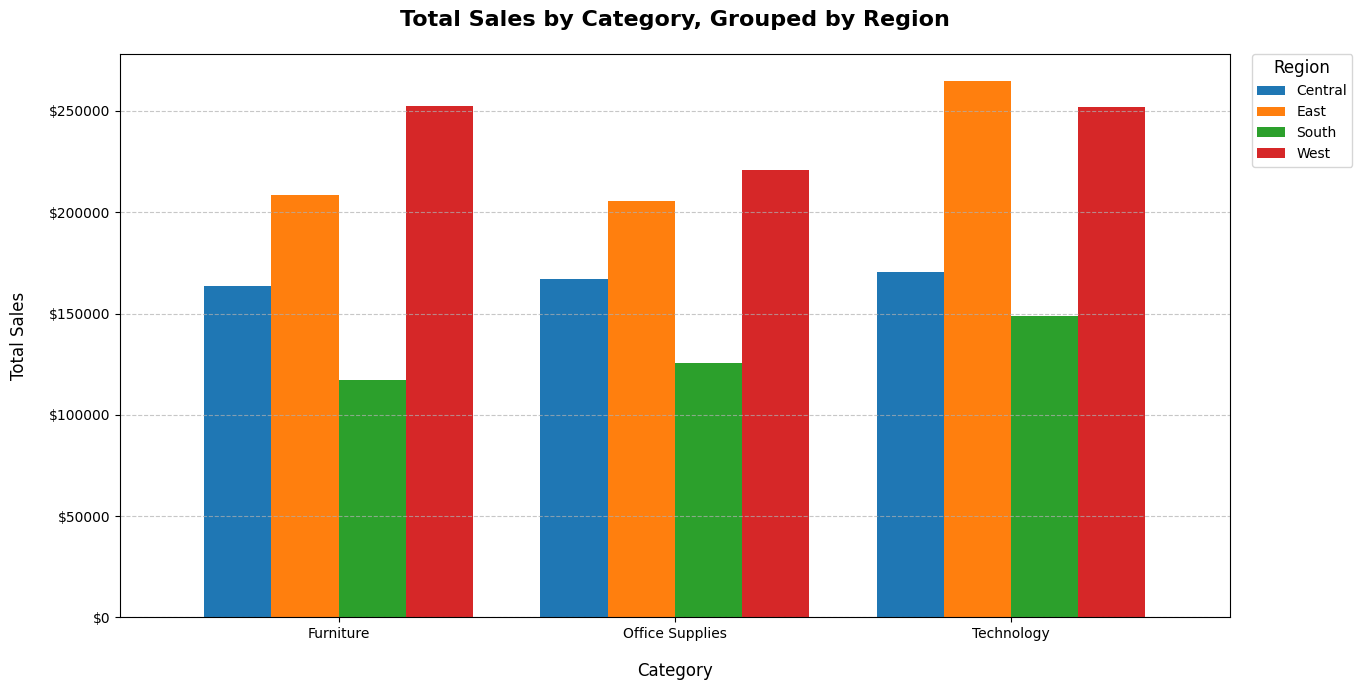

In [6]:
query = '''
SELECT region, category, SUM(sales) AS total_sales
FROM `mgmt599-samriddh-lab1.Assignment1.Store_dataset`
GROUP BY region, category
ORDER BY region, total_sales DESC
'''
category_mix = client.query(query).to_dataframe()

# Interchange region and category in the pivot table
category_pivot = category_mix.pivot(index='category', columns='region', values='total_sales').fillna(0)
# print(category_pivot) # You can comment this out if you only want the graph

# Plotting the bar graph with enhancements
ax = category_pivot.plot(kind='bar', figsize=(14, 7), width=0.8) # Adjust figsize and bar width
plt.title('Total Sales by Category, Grouped by Region', fontsize=16, fontweight='bold', pad=20) # Enhanced title
plt.xlabel('Category', fontsize=12, labelpad=15) # Label font size and padding
plt.ylabel('Total Sales', fontsize=12, labelpad=15) # Label font size and padding
plt.xticks(rotation=0, ha='center', fontsize=10) # Rotate and adjust font size for x-axis labels
plt.yticks(fontsize=10) # Adjust font size for y-axis labels

# Format y-axis to show currency (e.g., in dollars)
import matplotlib.ticker as mticker
formatter = mticker.FormatStrFormatter('$%.0f')
ax.yaxis.set_major_formatter(formatter)

# Place legend outside the plot to avoid overlapping bars
plt.legend(title='Region', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=10, title_fontsize='12')

plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a subtle y-grid for readability
plt.tight_layout(rect=[0, 0, 0.98, 1]) # Adjust layout, making space for the legend

plt.show()

**Insight:**
Our analysis of regional sales performance reveals that the West and East regions' dominant positions in overall sales are primarily driven by their specialized strengths in specific product categories. The West region demonstrates clear leadership in both the Furniture and Office Supplies categories, contributing significantly to its top-tier total sales. Conversely, the East region exhibits a strong advantage in Technology sales, a key factor in its high-ranking overall performance. This categorical specialization highlights the core drivers behind each region's success, providing actionable insights for targeted strategic initiatives.

**Summary of Investigation:**
- Shipping Consistency: Average shipping times are uniform across all four regions (approximately 3.9 days), indicating that shipping speed is not a significant factor in regional profitability differences.
- Central Region's Discount Impact: The Central region consistently applies higher discount rates, which correlates with and likely contributes to its lower profit margins.
- Regional Sales Specialization: The West and East regions' overall sales dominance stems from their specialized strengths: the West leads in Furniture and Office Supplies, while the East excels in Technology sales, highlighting category-specific drivers for their success.


### DIVE Step 3: Validate
**Focus: Outliers in Regional Profitability**

While our investigation identified regional differences in profitability and operational efficiency, these findings may be influenced by outlier transactions—orders with unusually high or low profit. Outliers can distort averages and mask the true underlying performance of a region.

In [7]:
query = '''
SELECT *,
  DATE_DIFF(ship_date, order_date, DAY) AS ship_time
FROM `mgmt599-samriddh-lab1.Assignment1.Store_dataset`
'''
df = client.query(query).to_dataframe()

C:\Users\Samriddh Gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


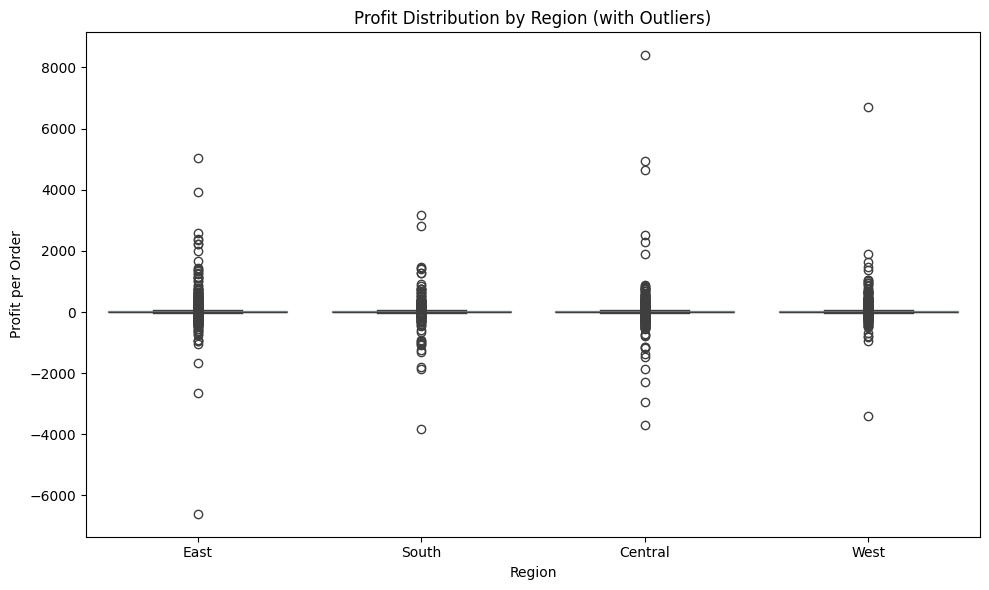

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='region', y='profit', data=df, showfliers=True, boxprops=dict(alpha=.5))
plt.title('Profit Distribution by Region (with Outliers)')
plt.ylabel('Profit per Order')
plt.xlabel('Region')
plt.tight_layout()
plt.show()

**Interpretation**

- Central Tendency Near Zero: For all four regions, the median profit per order (the horizontal line inside each box) is very close to zero. This suggests that the typical order in each region results in little to no profit or loss, often breaking even. The boxes themselves, representing the interquartile range (IQR - the middle 50% of the data), are also very narrow and centered around zero, reinforcing that the majority of orders are not highly profitable or loss-making.
- Presence of Numerous Outliers: Each region exhibits a substantial number of individual data points plotted as circles outside the "whiskers" of the box plots. These are the outliers, representing orders with exceptionally high or exceptionally low profits/losses compared to the bulk of orders in that region.
- Outliers Drive the Overall Range: The extreme values of these outliers (both positive and negative) are what dictate the overall y-axis scale of the plot (from approximately -7000 to +8000). Without these outliers, the boxes and whiskers would appear much larger and clearer, as the y-axis range would be significantly smaller.

### DIVE Step 4: Extend (Strategic Application)
Transform insights into action:

Based on our DIVE analysis, here are strategic recommendations to enhance business performance, focusing on regional profitability and operational efficiency.

**What should the business do?**
1. Central Region Profitability Initiative:
      - Action: Revise discounting strategy in the Central region. High average discounts correlate directly with negative profit margins.
      - Specifics: Re-evaluate discount thresholds, shift to targeted promotions for high-margin products, and provide sales training on value-based selling.
2. Leverage Regional Product Specialization:
      - Action: Capitalize on product mix strengths across regions.
      - Specifics: Replicate successful sales/marketing tactics from the West (Furniture/Office Supplies) and East (Technology) in other regions. Optimize inventory for high-performing categories and tailor marketing campaigns regionally.
3. Address Outlier-Driven Profit Swings:
      - Action: Understand and manage the impact of extreme profit/loss orders.
      - Specifics: Conduct post-mortem analyses for extreme orders to identify root causes. Develop policies to mitigate risks from high-loss orders and replicate conditions for high-profit successes.

**How can we measure impact?**
1. Profit Margin by Region:
   - Metric: Average Profit Margin (Central region).
   - Target: Central region profit margin to break-even (0%) within 6 months, matching South region's margin long-term.
   - Monitoring: Monthly review.

2. Discount Rate by Region:
   - Metric: Average Discount Percentage (Central region).
   - Target: Reduce Central region average discount by 5-10 percentage points within the next quarter without significant sales drop.
   - Monitoring: Weekly tracking.

3. Category Sales Growth:
   - Metric: Sales growth within key product categories (Furniture, Office Supplies, Technology) by region.
   - Target: 5% Q-o-Q growth in dominant categories within strong regions; 2-3% growth in underperforming regions.
   - Monitoring: Quarterly reports.

4. Outlier Frequency and Magnitude:

   - Metric: Number and average value of extreme profit/loss orders.
   - Target: Reduce high-loss outlier frequency by 15% and average loss magnitude by 10% within one year.
   - Monitoring: Monthly reports and root cause analysis.

**What are the risks?**
1. Sales Volume Decline (Central Region):
   - Risk: Reduced discounts may decrease sales.
   - Mitigation: Gradual changes, value-based marketing, improved customer service, loyalty programs, and close sales monitoring.

2. Resistance to Change:
   - Risk: Sales teams/managers may resist new policies.
   - Mitigation: Clear communication of findings, leadership involvement, training, and incentives.

3. Market Specificity Overlook:
   - Risk: Applying strategies without considering local market nuances.
   - Mitigation: Pilot programs, localized market research.

4. Data Interpretation Bias:
   - Risk: Over-reliance on historical data.
   - Mitigation: Continuous data updates, external market intelligence, and regular assumption re-validation.

By implementing these strategies, measuring their impact, and mitigating risks, the business can achieve more profitable and efficient regional operations.